# Fall 2024 Data Science Track: Week 5 - Unsupervised Learning

## Packages, Packages, Packages!

Import *all* the things here! You need: `matplotlib`, `networkx`, `numpy`, and `pandas`―and also `ast.literal_eval` to correctly deserialize two columns in the `rules.tsv.xz` file.

If you got more stuff you want to use, add them here too. 🙂

In [45]:
# Don’t worry about this. This is needed to interpret the Python code that is embedded in the data set. You only need it literally in the very next code cell and nowhere else. 
from ast import literal_eval

# The rest is just the stuff from the lecture.
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

# Instacart Association Rules

## Introduction

With the packages out of the way, now you will be working with the Instacart association rules data set, mined from the [Instacart Market Basket Analysis data set](https://www.kaggle.com/c/instacart-market-basket-analysis/data) on Kaggle. [The script](https://github.com/LiKenun/shopping-assistant/blob/main/api/preprocess_instacart_market_basket_analysis_data.py) that does it and the instructions to run it can be found in my [Shopping Assistant Project](https://github.com/LiKenun/shopping-assistant) repository.

## Load the Data

This code has already been pre-written, simply because there are a few quirks which require converters to ensure the correct deserialization of some columns.

In [46]:
rules_data_path = '/Users/estebanm/Desktop/2024-DS-Tue/Week-05-Unsupervised-Learning/data/rules.tsv.xz'

df_rules = pd.read_csv(
    rules_data_path,
    sep='\t',
    quoting=3,
    converters={
        'consequent_item': literal_eval,
        'antecedent_items': literal_eval
    },
    low_memory=True
)

print(df_rules.head())

<unknown>:1: SyntaxWarning: invalid escape sequence '\G'


                                     consequent_item  transaction_count  \
0  Total 2% with Raspberry Pomegranate Lowfat Gre...            3346083   
1  Total 2% Lowfat Greek Strained Yogurt With Blu...            3346083   
2   Total 0% with Honey Nonfat Greek Strained Yogurt            3346083   
3                          Total 0% Raspberry Yogurt            3346083   
4                                Pineapple Yogurt 2%            3346083   

   item_set_count  antecedent_count  consequent_count  \
0             101               123               128   
1             101               128               123   
2             101               123               128   
3             101               123               128   
4             101               128               123   

                                    antecedent_items  
0  [Fat Free Blueberry Yogurt, Pineapple Yogurt 2...  
1  [Fat Free Strawberry Yogurt, Total 0% Raspberr...  
2  [Fat Free Blueberry Yogurt, Pineapple 

But just *how* many rules were just loaded‽

In [47]:
# Show the list of column names and the number of rules.

print("column names:", df_rules.columns.to_list())

print("Number of rules: ", len(df_rules) )



column names: ['consequent_item', 'transaction_count', 'item_set_count', 'antecedent_count', 'consequent_count', 'antecedent_items']
Number of rules:  1048575


## Metrics

Compute the support, confidence, and lift of each rule.

* The rule’s *support* tells you how frequently the set of items appears in the dataset. It’s important to prune infrequent sets from further consideration.
    * The simple definition: $$P(A \cap B)$$
    * `= item_set_count / transaction_count`
* The rule’s *confidence* tells you how often a the rule is true. Divide the support for the set of items by the support for just the antecedents. Rules which are not true very often are also pruned.
    * The simple definition: $$\frac{P(A \cap B)}{P(A)}$$
    * `= item_set_count / transaction_count / (antecedent_count / transaction_count)`
    * `= item_set_count / antecedent_count`
* The rule’s *lift* tells you how much more likely the consequent is, given the antecedents, compared to its baseline probability. Divide the support for the set of items by both the support of the antecedents and consequent. Equivalently, divide the confidence by the support of the consequent.
    * The simple definition: $$\frac{P(A \cap B)}{P(A) \cdot P(B)}$$
    * `= item_set_count / transaction_count / (antecedent_count / transaction_count * (consequent_count / transaction_count))`
    * `= item_set_count / antecedent_count / (consequent_count / transaction_count)`
    * `= item_set_count * transaction_count / (antecedent_count * consequent_count)`

In [48]:
# Add new columns support, confidence, and lift to df_rules. And show the first 50 rules.
df_rules['support'] = df_rules['item_set_count'] / df_rules['transaction_count']

df_rules['confidence'] = df_rules['item_set_count'] / df_rules['antecedent_count']

df_rules['lift'] = (df_rules['item_set_count'] * df_rules['transaction_count']) / (df_rules['antecedent_count'] * df_rules['consequent_count'])

print(df_rules[['support', 'confidence', 'lift']].head(50))


     support  confidence          lift
0   0.000030    0.821138  21465.598514
1   0.000030    0.789062  21465.598514
2   0.000030    0.821138  21465.598514
3   0.000030    0.821138  21465.598514
4   0.000030    0.789062  21465.598514
5   0.000030    0.821138  21465.598514
6   0.000030    0.789062  21465.598514
7   0.000030    0.687075  19649.653061
8   0.000030    0.687075  19649.653061
9   0.000030    0.863248  19649.653061
10  0.000030    0.863248  19649.653061
11  0.000030    0.687075  19649.653061
12  0.000030    0.687075  19649.653061
13  0.000030    0.863248  19649.653061
14  0.000030    0.863248  19649.653061
15  0.000030    0.848739  19585.881368
16  0.000030    0.696552  19585.881368
17  0.000030    0.848739  19585.881368
18  0.000030    0.696552  19585.881368
19  0.000030    0.696552  19585.881368
20  0.000030    0.848739  19585.881368
21  0.000030    0.696552  19585.881368
22  0.000030    0.765152  19250.078776
23  0.000030    0.765152  19250.078776
24  0.000030    0.759398 

The yogurts have got some insane lift (*over 9,000*). Why do you think that might be?

*(Write your answer here.)*

The extremely high lift for yogurts, "over 9,000," shows us that yogurt is disproportionately purchased alongside certain other items, far more than expected by chance. This could be due to frequent pairings with items like granola, making yogurt and these items highly associated. Additionally, if yogurt has low standalone support meaning almost never show by itself in transactions—but frequently occurs with specific items, it would result in a high lift value.

In [49]:
# Query rules where yogurt appears as the antecedent or consequent
#first we create the yogurt rules to continue investigating
yogurt_rules = df_rules[(df_rules['antecedent_items'].str.contains('yogurt', case=False, na=False)) | 
                        (df_rules['consequent_item'].str.contains('yogurt', case=False, na=False))]

yogurt_rules.loc[:, 'support'] = yogurt_rules['item_set_count'] / yogurt_rules['transaction_count']
yogurt_rules.loc[:, 'confidence'] = yogurt_rules['item_set_count'] / yogurt_rules['antecedent_count']
yogurt_rules.loc[:, 'lift'] = (yogurt_rules['item_set_count'] * yogurt_rules['transaction_count']) / (yogurt_rules['antecedent_count'] * yogurt_rules['consequent_count'])


sorted_yogurt_rules = yogurt_rules.sort_values(by='lift', ascending=False)
print(sorted_yogurt_rules[['antecedent_items', 'consequent_item', 'support', 'confidence', 'lift']].head(10))



                                     antecedent_items  \
0   [Fat Free Blueberry Yogurt, Pineapple Yogurt 2...   
2   [Fat Free Blueberry Yogurt, Pineapple Yogurt 2...   
3   [Fat Free Blueberry Yogurt, Pineapple Yogurt 2...   
4   [Fat Free Strawberry Yogurt, Total 0% Raspberr...   
5   [Fat Free Blueberry Yogurt, Pineapple Yogurt 2...   
6   [Fat Free Strawberry Yogurt, Total 0% Raspberr...   
1   [Fat Free Strawberry Yogurt, Total 0% Raspberr...   
11  [Blackberry Yogurt, Fat Free Strawberry Yogurt...   
14  [Pineapple Yogurt 2%, Total 0% Raspberry Yogur...   
13  [Pineapple Yogurt 2%, Total 0% Raspberry Yogur...   

                                      consequent_item  support  confidence  \
0   Total 2% with Raspberry Pomegranate Lowfat Gre...  0.00003    0.821138   
2    Total 0% with Honey Nonfat Greek Strained Yogurt  0.00003    0.821138   
3                           Total 0% Raspberry Yogurt  0.00003    0.821138   
4                                 Pineapple Yogurt 2%  0.000

## Network Visualization for Consequents with Single Antecedents

Let’s now visualize a small subset of 1,000,000+ rules. First, filter the rule set for the following to whittle it down to something more manageable:

1. The rule must have exactly `1` antecedent item. (There should be 38,684 such rules.)
2. The lift must be between `5` and `20`. (There should be 1,596 such rules, including the prior criterion.)
3. Either the antecedent or consequent of the rule must contain `'Hummus'`, but not both. (This should get you down to 26 rules.)
    * Convert the antecedents `list`-typed column to a `str`-typed column (`antecedent_item`) since there will only be a single antecedent in the subset.
    * Replace any item containing `'Hummus'` to just `'Hummus'`. This will make the visualization more readable later.

Hint: your code may run more efficiently if you re-order certain processing steps.

Assign the subset to `df_rules_subset`.

In [55]:
df_rules_subset = df_rules[df_rules['antecedent_items'].str.len() == 1]

df_rules_subset = df_rules_subset[(df_rules_subset['lift'] >= 5) & (df_rules_subset['lift'] <= 20)]

condition_consequent = df_rules_subset['consequent_item'].str.contains('Hummus', case=False, na=False)
df_rules_subset = df_rules_subset[condition_consequent]

df_rules_subset['antecedent_items'] = df_rules_subset['antecedent_items'].astype(str)
condition_antecedent = ~df_rules_subset['antecedent_items'].str.contains('Hummus', case=False, na=False)
df_rules_subset = df_rules_subset[condition_antecedent]

df_rules_subset.rename(columns={"antecedent_items": "antecedent_item"}, inplace=True)

len(df_rules_subset)


19

Build a network `graph_rules_subset` from the association rules subset.

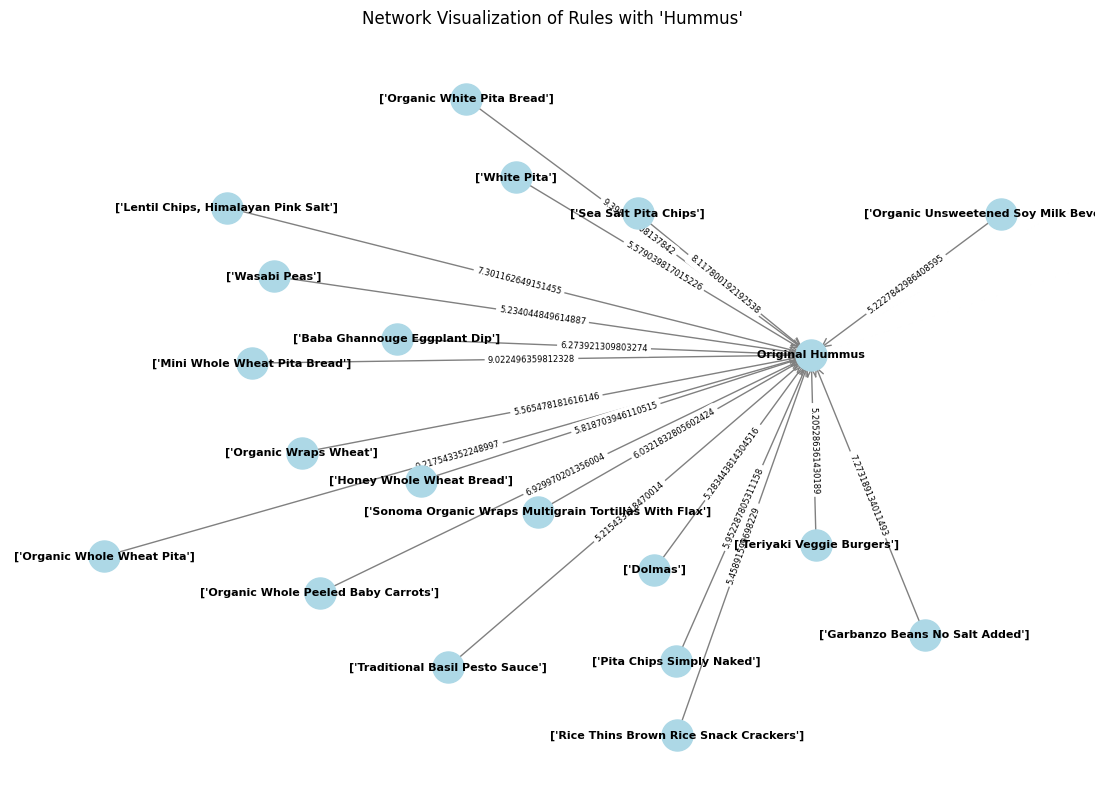

In [51]:
# Define graph_rules_subset, add the graph’s edges, and plot it. You may need a large figure size, smaller node size, and smaller font size.

graph_rules_subset = nx.MultiDiGraph()
graph_rules_subset.add_edges_from(
    (row['antecedent_item'], row['consequent_item'], {'lift': row['lift']}) 
    for _, row in df_rules_subset.iterrows()
)

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(graph_rules_subset, seed=42)

nx.draw_networkx_nodes(graph_rules_subset, pos, node_color='lightblue', node_size=500)
nx.draw_networkx_labels(graph_rules_subset, pos, font_size=8, font_weight='bold')
nx.draw_networkx_edges(graph_rules_subset, pos, arrowstyle='->', arrowsize=15, edge_color='gray')

edge_labels = {(row['antecedent_item'], row['consequent_item']): f"{row['lift']}" for _, row in df_rules_subset.iterrows()}
nx.draw_networkx_edge_labels(graph_rules_subset, pos, edge_labels=edge_labels, font_size=6)

plt.title("Network Visualization of Rules with 'Hummus'")
plt.axis('off')
plt.show()

# Then render the graph.

What can you tell about people who buy hummus?

*(Write your answer here.)*

## Make a Prediction

Given that the basket of items contains the following items, use the full set of association rules to predict the next 20 most likely items (consequents) that the person will add to the basket in descending order of lift:

* `'Orange Bell Pepper'`
* `'Organic Red Bell Pepper'`

Hint: a single item in the basket may be a better predictor of some consequents than both items considered together. You must consider both or either, but not neither.

In [58]:
basket = {'Orange Bell Pepper', 'Organic Red Bell Pepper'}

df_predictions = df_rules[
    (df_rules['antecedent_items'].apply(lambda x: 'Orange Bell Pepper' in x or 'Organic Red Bell Pepper' in x)) &
    (df_rules['antecedent_items'].apply(lambda x: set(x).issubset(basket) or any(item in basket for item in x)))
]

df_predictions = df_predictions.sort_values('lift', ascending=False).head(20)

print(df_predictions)


                                          consequent_item  transaction_count  \
342462      Icelandic Style Skyr Blueberry Non-fat Yogurt            3346083   
345882      Icelandic Style Skyr Blueberry Non-fat Yogurt            3346083   
346832           Nonfat Icelandic Style Strawberry Yogurt            3346083   
346901                           Non Fat Raspberry Yogurt            3346083   
349532      Icelandic Style Skyr Blueberry Non-fat Yogurt            3346083   
350852      Icelandic Style Skyr Blueberry Non-fat Yogurt            3346083   
350991                           Non Fat Raspberry Yogurt            3346083   
351360      Icelandic Style Skyr Blueberry Non-fat Yogurt            3346083   
351433           Nonfat Icelandic Style Strawberry Yogurt            3346083   
351881      Icelandic Style Skyr Blueberry Non-fat Yogurt            3346083   
352283                         Vanilla Skyr Nonfat Yogurt            3346083   
352884                        Organic Fr

## Bonus: Other Interesting Findings

Find and share something else interesting about these association rules. It can be a graph, table, or some other format that illustrates your point.

In [60]:
top_confidence_pairs = df_rules.sort_values('confidence', ascending=False).head(10)
print(top_confidence_pairs[['antecedent_items', 'consequent_item', 'confidence']])


                                         antecedent_items  \
332069  [Cherry Pomegranate Greek Yogurt, Total 0% Non...   
317500  [Blackberry Yogurt, Total 0% with Honey Nonfat...   
315930  [Cherry Pomegranate Greek Yogurt, Total 0% Ras...   
315929  [Cherry Pomegranate Greek Yogurt, Total 0% Non...   
315928  [Cherry Pomegranate Greek Yogurt, Total 0% Non...   
315927  [Cherry Pomegranate Greek Yogurt, Total 0% Non...   
315926  [Cherry Pomegranate Greek Yogurt, Total 2% All...   
315925  [Cherry Pomegranate Greek Yogurt, Total 2% All...   
315924  [Cherry Pomegranate Greek Yogurt, Total 2% All...   
317502  [Blackberry Yogurt, Pineapple Yogurt 2%, Total...   

                                          consequent_item  confidence  
332069  Total 2% with Strawberry Lowfat Greek Strained...         1.0  
317500  Total 2% Lowfat Greek Strained Yogurt With Blu...         1.0  
315930   Total 2% Lowfat Greek Strained Yogurt with Peach         1.0  
315929   Total 2% Lowfat Greek Strained 

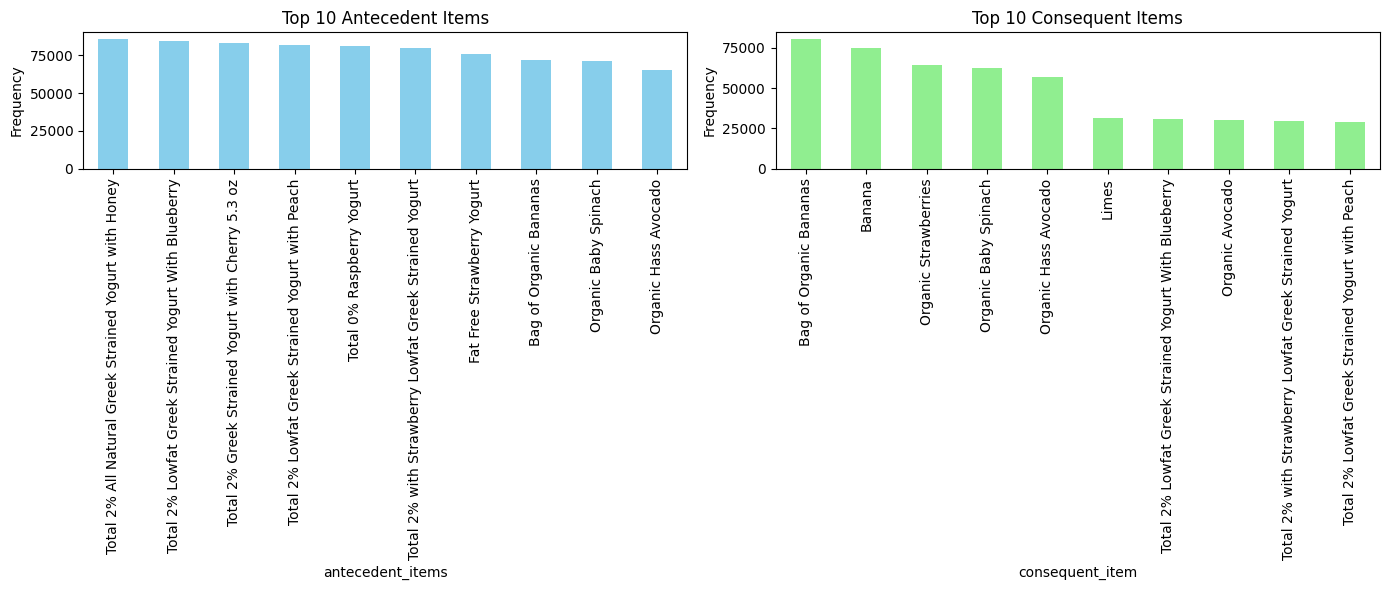

In [61]:
top_antecedents = df_rules['antecedent_items'].explode().value_counts().head(10)
top_consequents = df_rules['consequent_item'].value_counts().head(10)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
top_antecedents.plot(kind='bar', color='skyblue')
plt.title('Top 10 Antecedent Items')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
top_consequents.plot(kind='bar', color='lightgreen')
plt.title('Top 10 Consequent Items')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()